In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Ryan.Models.LSTM_model_Regression.preprocess import preprocess_data
from Ryan.Models.LSTM_model_Regression.lstm_models import  LSTMModel, LSTMModel_multi
from Ryan.Models.LSTM_model_Regression.run_fn import eval_fn, train_fn
from Ryan.Models.LSTM_model_Regression.load_data import load_data, create_sequences
from Ryan.Models.LSTM_model_Regression.load_data import load_data2
import torch
#from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'get_linear_schedule_with_warmup' from 'transformers' (D:\anaconda\Lib\site-packages\transformers\__init__.py)

In [19]:
lob_data=pd.read_csv('resampled_lob_secs2.csv')

loaded_pred=np.load('./saved_models_regression/preds_array.npy')
loaded_true=np.load('./saved_models_regression/actuals_array.npy')
#loaded_pred_adjusted=loaded_pred-14
loaded_pred_adjusted=loaded_pred-14

In [52]:
print(loaded_pred.shape)
print(loaded_true.shape)

(376699, 10)
(376699, 10)


In [13]:
split_index=int(0.9*len(lob_data))
train_data=lob_data.iloc[:split_index]
test_data=lob_data.iloc[split_index:]
test_set=test_data[21:-9]

test_set.reset_index(drop=True, inplace=True) # drop=True to avoid the old index being added as a column
test_set

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum
0,2025-06-13 04:28:47,256,109,193.000000,30,17,4,3,-7,56.384379,229.600000,83.142857
1,2025-06-13 04:28:48,274,112,184.000000,30,17,4,5,1,55.606061,244.400000,74.000000
2,2025-06-13 04:28:49,390,110,196.153846,39,17,4,9,-13,39.854729,224.630769,-98.846154
3,2025-06-13 04:28:50,207,109,126.818182,39,16,2,9,-7,16.606580,166.594406,-290.181818
4,2025-06-13 04:28:51,156,109,117.545455,39,17,2,9,2,45.163267,163.503497,-15.454545
...,...,...,...,...,...,...,...,...,...,...,...,...
376694,2025-07-01 08:17:46,101,80,90.500000,14,12,3,3,0,0.000000,105.406667,-35.500000
376695,2025-07-01 08:17:47,100,75,93.750000,14,15,3,1,2,9.535452,99.890000,-27.583333
376696,2025-07-01 08:17:48,98,79,86.600000,14,17,2,3,5,10.517799,95.010000,-24.400000
376697,2025-07-01 08:17:49,99,76,93.250000,13,18,6,2,-8,30.414747,92.460000,-12.750000


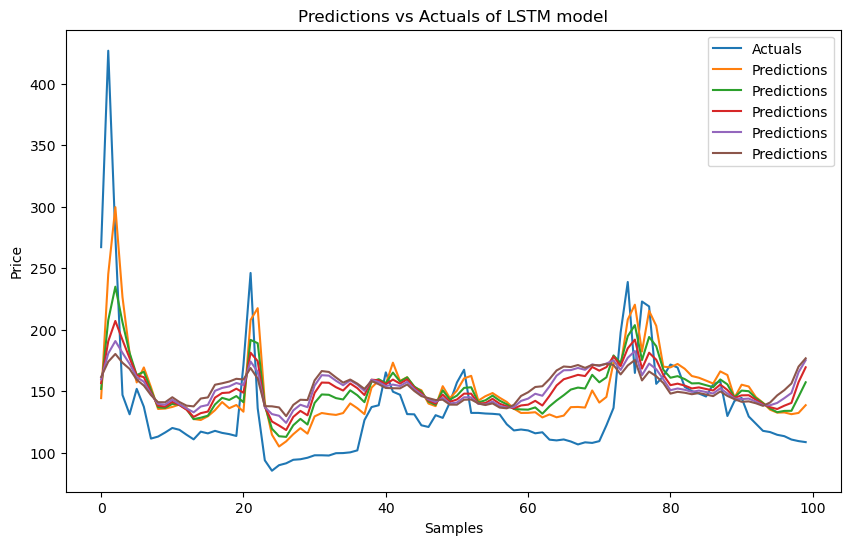

In [18]:
# use the true price in test set and predicted price to plot
plt.figure(figsize=(10,6))
plt.plot(test_set['price'][500:600].values, label='Actuals')
plt.plot(loaded_pred[500:600,0:5], label='Predictions')
plt.legend()
plt.title('Predictions vs Actuals of LSTM model')
plt.ylabel('Price')
plt.xlabel('Samples')
plt.show()

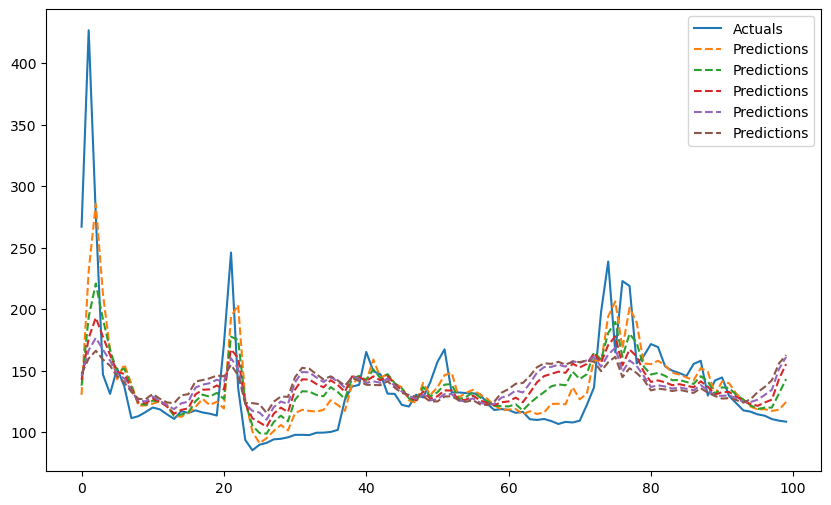

In [22]:
# adjust predicitons
loaded_pred_adjusted=loaded_pred-14

# plot
plt.figure(figsize=(10,6))
plt.plot(test_set['price'].values[500:600], label='Actuals')
plt.plot(loaded_pred_adjusted[500:600,0:5], label='Predictions',linestyle='dashed')
plt.legend()

In [25]:
# This is only for trading volume, not for modeling
# # 设置一个时间窗口
rolling_window = 5  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
test_set['Log Return Max Bid'] = np.log(test_set['Max Bid Price'] / test_set['Max Bid Price'].shift(1))
test_set['Log Return Min Ask'] = np.log(test_set['Min Ask Price'] / test_set['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
test_set['Volatility Max Bid'] = test_set['Log Return Max Bid'].rolling(window=rolling_window).std()
test_set['Volatility Min Ask'] = test_set['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
# lob_data.dropna(inplace=True)

# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_factor=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    scaler_factor: 缩放因子，用于进一步调整基于波动率的交易量
    """
    # 确保风险容忍度和波动率不会导致除以0
    if volatility <= 0.0001:
        volatility = 0.0001
    if risk_tolerance <= 0:
        risk_tolerance = 0.1  # 设置一个默认的风险容忍度，避免除以0

    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility * risk_tolerance * scaler_factor)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3580164283.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Log Return Max Bid'] = np.log(test_set['Max Bid Price'] / test_set['Max Bid Price'].shift(1))
C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3580164283.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Log Return Min Ask'] = np.log(test_set['Min Ask Price'] / test_set['Min Ask Price'].shift(1))
C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3580164283.py:10: SettingWit

In [27]:
# short term EMA
ema_short = test_set['price'].ewm(span=300, adjust=False).mean()
# long term EMA
ema_long = test_set['price'].ewm(span=600, adjust=False).mean()
# MACD line
macd = ema_short - ema_long
# signal line
signal = macd.ewm(span=60, adjust=False).mean()
# histogram
histogram = macd - signal

# 把计算出的MACD指标添加到dataframe
test_set['MACD Line'] = macd
test_set['MACD Signal'] = signal
test_set['MACD Histogram'] = histogram

C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3153781285.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Line'] = macd
C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3153781285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Signal'] = signal
C:\Users\31207\AppData\Local\Temp\ipykernel_54972\3153781285.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [28]:
## generate signal based on MACD
# 通过比较MACD线和信号线的前后值来确定交叉
test_set['MACD Trade Signal'] = 0
test_set.loc[(test_set['MACD Line'] > test_set['MACD Signal']) &  # MACD线上穿信号线
       (test_set['MACD Line'].shift(1) <= test_set['MACD Signal'].shift(1)), 'MACD Trade Signal'] = 1
test_set.loc[(test_set['MACD Line'] < test_set['MACD Signal']) &  # MACD线下穿信号线
       (test_set['MACD Line'].shift(1) >= test_set['MACD Signal'].shift(1)), 'MACD Trade Signal'] = -1

C:\Users\31207\AppData\Local\Temp\ipykernel_54972\487417816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Trade Signal'] = 0


In [49]:
initial_capital = 10000
capital = initial_capital
has_position = False
trade_log = []
# capital_history = [initial_capital]
current_holdings = 0
transaction_cost = 0.005
# trade_quantity = 1


#设置交易条件
for i in range(len(test_set)-1):
    # skip the iteration if there is any missing value
    if test_set.iloc[i].isna().any():
        continue
    
    current_true = test_set['price'][i] # current true price
    current_predict = loaded_pred_adjusted[i] # current predicted price
    next_predict = loaded_pred_adjusted[i+1] # next predicted price
    
    # adjust the trade quantity based on the volatility. make the trade quantity no more than the max tradeable quantity
    current_volatility_buy = test_set['Volatility Min Ask'].iloc[i]
    current_volatility_sell = test_set['Volatility Max Bid'].iloc[i]
    
    # get other indicators
    ofi = test_set['ofi'].iloc[i]
    rsi = test_set['RSI'].iloc[i]
    macd_signal = test_set['MACD Trade Signal'].iloc[i]
    
    # check if the first 5 predictions all indicate an uptrend
    if all(current_predict[j+1] > current_predict[j] for j in range(4)):
        # buy policy: only buy if the next predicted price is significantly higher and MACD signal is 1
        #if next_predict[0] > current_predict[0] * 1.1 and macd_signal == 1:
        if next_predict[0] > current_predict[0] * 1.1 and rsi<30 :
            # buy policy
            buy_price = current_true
            buy_quantity = adjust_trade_quantity(current_volatility_buy, test_set['Min Ask Quantity'].iloc[i], scaler_factor=10)
            capital -= buy_price * buy_quantity * (1 + transaction_cost)
            current_holdings += buy_quantity
            if current_holdings > 0:
                has_position = True
            trade_log.append({'action': 'BUY', 'Time': test_set['Datetime'].iloc[i], 'price': buy_price,
                              'capital': capital, 'quantity': buy_quantity,
                              'max quantity': test_set['Min Ask Quantity'].iloc[i]})
    # check if the first 5 predictions all indicate a downtrend
    elif all(current_predict[j+1] < current_predict[j] for j in range(4)):
        # sell policy: only sell if the next predicted price is significantly lower or MACD signal is -1
        #if next_predict[0] < current_predict[0] * 0.9 or macd_signal == -1:
        if current_holdings > 0 and next_predict[0] < current_predict[0] * 0.9 and rsi>70 :
            # sell policy
            sell_price = current_true
            sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, test_set['Max Bid Quantity'].iloc[i], scaler_factor=20))
            capital += sell_price * sell_quantity * (1 - transaction_cost)
            current_holdings -= sell_quantity
            if current_holdings == 0:
                has_position = False
            trade_log.append({'action': 'SELL', 'Time': test_set['Datetime'].iloc[i], 'price': sell_price,
                              'capital': capital, 'quantity': sell_quantity,
                              'max quantity': test_set['Max Bid Quantity'].iloc[i]})
    else:
        # hold policy
        trade_log.append({'action': 'HOLD', 'Time': test_set['Datetime'].iloc[i],
                          'price': test_set['price'].iloc[i], 'capital': capital,
                          'quantity': current_holdings})



# 计算最终资本
final_capital = capital
profit = final_capital - initial_capital

# 计算买入和卖出的次数
number_of_buy = len([trade for trade in trade_log if trade['action'] == 'BUY'])
number_of_sell = len([trade for trade in trade_log if trade['action'] == 'SELL'])
number_of_hold = len([trade for trade in trade_log if trade['action'] == 'HOLD'])
daily_profit=profit/(number_of_buy+number_of_sell)
# 打印结果
print('Profit: ', round(profit))
print('Number of buys: ', number_of_buy)
print('Number of sells: ', number_of_sell)
print('Number of holds: ', number_of_hold)
print(daily_profit)

Profit:  302610
Number of buys:  2819
Number of sells:  2580
Number of holds:  94242
56.049257495448835


In [47]:
test_df=test_set.reset_index()
test_df

,index,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,...,MA,Momentum,Log Return Max Bid,Log Return Min Ask,Volatility Max Bid,Volatility Min Ask,MACD Line,MACD Signal,MACD Histogram,MACD Trade Signal
0,0,2025-06-13 04:28:47,256,109,193.000000,30,17,4,3,-7,...,229.600000,83.142857,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0
1,1,2025-06-13 04:28:48,274,112,184.000000,30,17,4,5,1,...,244.400000,74.000000,0.027151,0.067951,NaN,NaN,-0.029851,-0.000979,-0.028872,-1
2,2,2025-06-13 04:28:49,390,110,196.153846,39,17,4,9,-13,...,224.630769,-98.846154,-0.018019,0.353019,NaN,NaN,-0.019092,-0.001573,-0.017520,0
3,3,2025-06-13 04:28:50,207,109,126.818182,39,16,2,9,-7,...,166.594406,-290.181818,-0.009132,-0.633428,NaN,NaN,-0.238409,-0.009338,-0.229071,0
4,4,2025-06-13 04:28:51,156,109,117.545455,39,17,2,9,2,...,163.503497,-15.454545,0.000000,-0.282863,NaN,NaN,-0.486293,-0.024976,-0.461317,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376694,376694,2025-07-01 08:17:46,101,80,90.500000,14,12,3,3,0,...,105.406667,-35.500000,-0.150573,-0.048319,0.064514,0.047635,2.650494,2.017303,0.633191,0
376695,376695,2025-07-01 08:17:47,100,75,93.750000,14,15,3,1,2,...,99.890000,-27.583333,-0.064539,-0.009950,0.054220,0.046103,2.495394,2.032978,0.462416,0
376696,376696,2025-07-01 08:17:48,98,79,86.600000,14,17,2,3,5,...,95.010000,-24.400000,0.051960,-0.020203,0.077306,0.015592,2.318067,2.042325,0.275742,0
376697,376697,2025-07-01 08:17:49,99,76,93.250000,13,18,6,2,-8,...,92.460000,-12.750000,-0.038715,0.010152,0.077229,0.022895,2.164510,2.046331,0.118179,0


In [48]:
# 截取一部分测试数据
sample_set = test_df[(test_df['Datetime'] >= '2025-06-13 00:00:00') & (test_df['Datetime'] <= '2025-06-30 23:59:59')]

start_of_trade = sample_set.index[0]
end_of_trade = sample_set.index[-1]
len(sample_set), start_of_trade, end_of_trade

(242179, 13878, 256056)

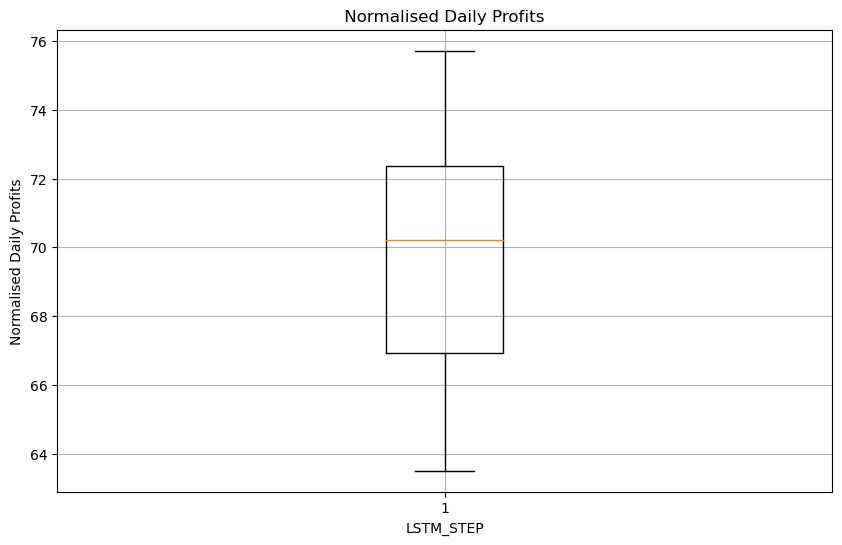

In [51]:
import matplotlib.pyplot as plt

def run_strategy(sample_set, initial_capital, loaded_pred_adjusted):
    daily_profits = []
    
    for day in range(16, 26):
        start_timestamp = f'2025-06-{day:02d} 00:00:00'
        end_timestamp = f'2025-06-{day:02d} 23:59:59'
        
        daily_data = sample_set[(sample_set['Datetime'] >= start_timestamp) & (sample_set['Datetime'] <= end_timestamp)]
        
        if not daily_data.empty:
            capital = initial_capital
            current_holdings = 0
            trade_log = []

            for i in range(len(daily_data) - 1):
                # Trading logic
                current_true = daily_data['price'].iloc[i]
                current_predict = loaded_pred_adjusted[i]
                next_predict = loaded_pred_adjusted[i+1]

                # Adjust the trade quantity based on the volatility
                current_volatility_buy = daily_data['Volatility Min Ask'].iloc[i]
                current_volatility_sell = daily_data['Volatility Max Bid'].iloc[i]

                # Get other indicators
                ofi = daily_data['ofi'].iloc[i]
                rsi = daily_data['RSI'].iloc[i]
                macd_signal = daily_data['MACD Trade Signal'].iloc[i]
                            # check if the first 5 predictions all indicate an uptrend
                if all(current_predict[j+1] > current_predict[j] for j in range(4)):
                    # buy policy: only buy if the next predicted price is significantly higher and MACD signal is 1
                    #if next_predict[0] > current_predict[0] * 1.1 and macd_signal == 1:
                    if next_predict[0] > current_predict[0] * 1.1 and rsi<30 :
                        # buy policy
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, test_set['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        if current_holdings > 0:
                            has_position = True
                        trade_log.append({'action': 'BUY', 'Time': test_set['Datetime'].iloc[i], 'price': buy_price,
                                          'capital': capital, 'quantity': buy_quantity,
                                          'max quantity': test_set['Min Ask Quantity'].iloc[i]})
                # check if the first 5 predictions all indicate a downtrend
                elif all(current_predict[j+1] < current_predict[j] for j in range(4)):
                    # sell policy: only sell if the next predicted price is significantly lower or MACD signal is -1
                    #if next_predict[0] < current_predict[0] * 0.9 or macd_signal == -1:
                    if current_holdings > 0 and next_predict[0] < current_predict[0] * 0.9 and rsi>70 :
                        # sell policy
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, test_set['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': test_set['Datetime'].iloc[i], 'price': sell_price,
                                          'capital': capital, 'quantity': sell_quantity,
                                          'max quantity': test_set['Max Bid Quantity'].iloc[i]})
                else:
                    # hold policy
                    trade_log.append({'action': 'HOLD', 'Time': test_set['Datetime'].iloc[i],
                                      'price': test_set['price'].iloc[i], 'capital': capital,
                                      'quantity': current_holdings})
               

            final_capital = capital
            profit = final_capital - initial_capital
            number_of_buy = len([trade for trade in trade_log if trade['action'] == 'BUY'])
            number_of_sell = len([trade for trade in trade_log if trade['action'] == 'SELL'])
            daily_profits.append(profit / (number_of_buy + number_of_sell))
    
    return daily_profits

# Initialize a dictionary to store daily profits for each strategy


# Run each strategy and store its daily profits
daily_profits = run_strategy(sample_set, initial_capital, loaded_pred_adjusted)

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot(daily_profits)
plt.title(' Normalised Daily Profits ')
plt.xlabel('LSTM_STEP')
plt.ylabel('Normalised Daily Profits')
plt.grid(True)
plt.show()
